In [40]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.figsize"] = (8,5)
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12


Fluido 1 en dirección x lateral a tubos (gas)

Fluido 2 en dirección y, area transversal de tubos en plano xz (oil)

### Parámetros Intercambiador

In [41]:
def propiedades_tubos():
    kt = 40
    do = 48.26 
    di = 40.89
    do *= 10**(-3)
    di *= 10**(-3)
    ro = do/2
    ri = di/2
    return kt,do,di,ro,ri

def propiedades_aletas():
    kf = 386
    de = 79
    t = 1
    sigmaf = 275
    de *= 10**(-3)
    t *= 10**(-3)
    re = de/2
    N_aletas = sigmaf*Ly
    return kf,de,t,sigmaf,re,N_aletas

    
#función para calcular la eficiencia de las aletas
def calcular_etaf():
    r_pp = re/ro
    Le = re - ro + t/2
    m_pp = np.sqrt(2*h1/(kf*t))
    if r_pp<=2:
        b = 0.9107 + 0.0893*r_pp
    else:
        b = 0.9706 + 0.17125*np.log(r_pp)
    n_pp = np.exp(0.13*m_pp*Le-1.3863)
    phi_pp = m_pp*Le*(r_pp**n_pp)
    if phi_pp <= 0.6 + 2.257*r_pp**(-0.445):
        eta_0 = np.tanh(phi_pp)/phi_pp
    else:
        eta_0 = r_pp**(-0.246)*(m_pp*Le)**(-b)
    Ab = 2*np.pi*ro*(Ly - t*N_aletas)
    A0 = np.pi*re**2-np.pi*ro**2 + 2*np.pi*re*t
    eta_f = (Ab + eta_0*N_aletas*A0)/(Ab + N_aletas*A0)
    return eta_f


### Propiedades de los gases

In [42]:
#Propiedades gas

def cp_gas(T):
    a = 1.0147 + 3.3859*10**(-4)*T - 1.6631*10**(-6)*(T**2) + 3.5452*10**(-9)*T**3
    b = - 2.8851*10**(-12)*T**4 + 8.1731*10**(-16)*T**5
    return (a+b)*10**3

def viscosidad_gas(T):
    a = 1.751*10**(-6) + 6.4458*10**(-8)*T - 4.1435*10**(-11)*T**2
    b = 1.8385*10**(-14)*T**3 - 3.2051*10**(-18)*T**4
    return a+b

def conductividad_gas(T):
    a = 1.9955*10**(-4) + 9.9744*10**(-5)*T - 4.8142*10**(-8)*T**2
    b = 1.614*10**(-11)*T**3 - 3.176*10**(-15)*T**4
    return a+b

def densidad_gas(T):
    P = 120
    R = 0.297
    return P/(R*T)

def Pr_gas(T):
    return cp_gas(T)*viscosidad_gas(T)/conductividad_gas(T)

In [43]:
# Función para calcular h1
def calcular_h1():
    u_max = m1/(rho1*Ly*(Nf*(Z-do) - sigmaf*(de-do)*t))
    Re = rho1*u_max*do/miu1
    if 0<= Re and Re < 10**2:
        C = 0.9
        alpha = 0.4
        beta = 0.36
    elif 10**2 <= Re and Re < 10**3:
        C = 0.52
        alpha = 0.5
        beta = 0.36
    elif 10**3 <= Re and Re < 2*10**5:
        C = 0.27
        alpha = 0.63
        beta = 0.36
    elif 2*10**5 <= Re and Re < 2*10**6:
        C = 0.033
        alpha = 0.8
        beta = 0.4
    else:
        print(f'Fuera de rango {Re}')
    
    Nu = C*Re**alpha*Pr1**beta
    h = k1*Nu/do
    return h 



### Propiedades del aceite

In [44]:
# Propiedades del aceite

def cp_oil(T):
    return (0.81554 + 0.00364*T)*10**3

def densidad_oil(T):
    return 1040.3 - 0.60477*T

def viscosidad_oil(T):
    a = 81.541 - 0.61584*T + 1.7943*10**(-3)*T**2
    b = -2.3678*10**(-6)*T**3 + 1.1763*10**(-9)*T**4
    return np.exp(a+b)*10**(-3)

def conductividad_oil(T):
    a = -7.5722*10**(-2) + 2.5952*10**(-3)*T - 1.2033*10**(-5)*T**2
    b = 2.653*10**(-8)*T**3 - 2.8663*10**(-11)*T**4 + 1.2174*10**(-14)*T**5
    return a+b

def Pr_oil(T):
    return cp_oil(T)*viscosidad_oil(T)/conductividad_oil(T)

In [45]:
# Función para h2
def h2_ij(i,j):
    Re = 4*m2[i]/(np.pi*di*miu2)
    if Re > 3000 and Re < 5*10**6:
        f = 0.00512 + 0.4572*Re**(-0.311)
        Nu = ((f/8)*(Re-1000)*Pr_oil(T2[i,j]))/(1+12.7*(f/8)**0.5*(Pr_oil(T2[i,j])**(2/3)-1))
        
    else:
        Nu = 4.36
    h = conductividad_oil(T2[i,j])*Nu/di
    return h


In [46]:
# Función para calcular constantes
def calcular_constantes():
    dy = Ly/Ny
    n = N_aletas/Ny
    dA1b = 2*np.pi*ro*(dy-n*t)
    dA1f = 2*np.pi*n*(re**2-ro**2+re*t)
    dA1 = dA1b + dA1f
    dA2 = 2*np.pi*ri*dy
    Rw = np.log(ro/ri)/(2*np.pi*kt*dy)
    return dy,dA1,dA2,Rw

# Función para calcular U_ij
def calcular_Uij():
    U = (dA2/(h1*eta_f*dA1) + dA2*Rw + 1/h2)**(-1)
    return U

### Gráficos

In [47]:
# Función para crear los 3 gráficos
def graficar():
    
    x = np.linspace(1,Nc,Nc)
    plt.plot(x,T1[0:Nc],c='k', ls='-', marker='.', label="T1[i]")
    plt.title("Distribución de Temperatura del gas a lo largo del eje x")
    plt.ylabel("T1 [°C]")
    plt.xlabel("Columnas")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    
    x = np.linspace(1,Nc,Nc)
    plt.plot(x,T2[:,Ny],c='k', ls='-', marker='.',label="T2[i]")
    plt.title("Distribución de Temperatura del aceite a la salida")
    plt.ylabel("T2 [°C]")
    plt.xlabel("Columnas")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    fig = plt.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    y = np.linspace(1,Nc,Nc)
    x = np.linspace(0,Ly,Ny+1)
    X,Y = np.meshgrid(x,y)
    surf = ax.plot_surface(Y,X,T2, cmap='coolwarm');
    fig.colorbar(surf, shrink=0.5, aspect=5, label="T2 [°C]")
    plt.title("Distribución de la Temperatura del Aceite a lo Largo del Intercambiador");
    plt.ylabel("Distancia a lo Largo del Tubo")
    plt.xlabel("Columnas")
    #ax.set_zlabel('T2')
    fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c='k', marker = 's')
    ax.legend([fake2Dline], ['Temperatura del Aceite'], numpoints = 1);

In [48]:
# Función para guardar como csv
def save_csv():
    mydir = os.path.join(os.getcwd(),"data")
    check_folder = os.path.isdir(mydir)
    if not check_folder:
        os.makedirs(mydir) 
    path_T1 = os.path.join(mydir,'T1.csv')
    path_T2_ex = os.path.join(mydir,'T2_exit.csv')
    path_T2_com = os.path.join(mydir,'T2_complete.csv') 
    df1 = pd.DataFrame(np.round(T1,decimals=2))
    df1.to_csv(path_T1,header=None) 
    df2 = pd.DataFrame(np.round(T2[:,Ny],decimals=2))
    df2.to_csv(path_T2_ex,header=None)
    df2 = pd.DataFrame(T2)
    df2.to_csv(path_T2_com)
        

### Temperaturas

In [49]:
# Función para pedir parámetros a usuario
def pedir_parametros():
    print("Ingresar parámetros para intercambiador de calor: ")
    Nf = input("Número de filas de tubos: ")
    Nc = input("Número de columnas de tubos: ")
    Ly = input("Largo de tubos [m]: ")
    Z = input("Separación vertical de tubos [mm]: ")
    Ny = input("Elementos discretización longitudinal: ")
    m1 = input("Flujo másico de gas [kg/s]: ")
    m2 = input("Flujo másico de aceite [kg/s]: ")
    print("Distribución de flujo másico")
    print("0: uniforme, 1: triangular, 2: creciente, 3: decreciente")
    dis = input("Selección: ")
    return (Nf,Nc,Ly,Z*10**(-3),Ny,m1,m2,dis)


In [50]:

def pedir_parametros():
    Nf = 40
    Nc = 100
    Ly = 4
    Z = 81
    Ny = 44
    m1 = 1
    m2 = 0.5
    dis = 0
    return (Nf,Nc,Ly,Z*10**(-3),Ny,m1,m2,dis)

### Loop para resolver



----------------------
Tamaño del Intercambiador:
Alto: 3.24 [m]
Ancho: 8.1 [m]
Largo: 4.0 [m]
----------------------
Resultados:
Número de iteraciones 3
Temperatura de salida del gas: 537.1 [°C]
Temperatura de salida del aceite: 279.7 [°C]
Flujo de calor total transferido: 303.7 [kW]


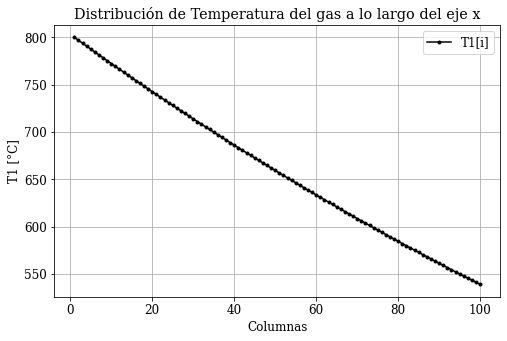

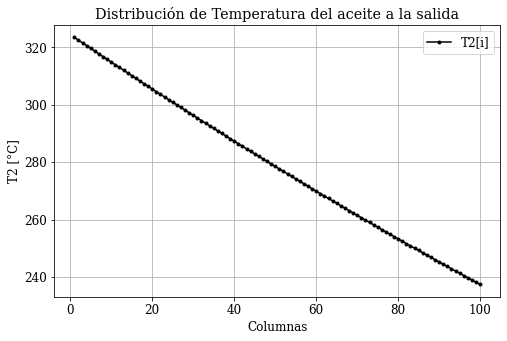

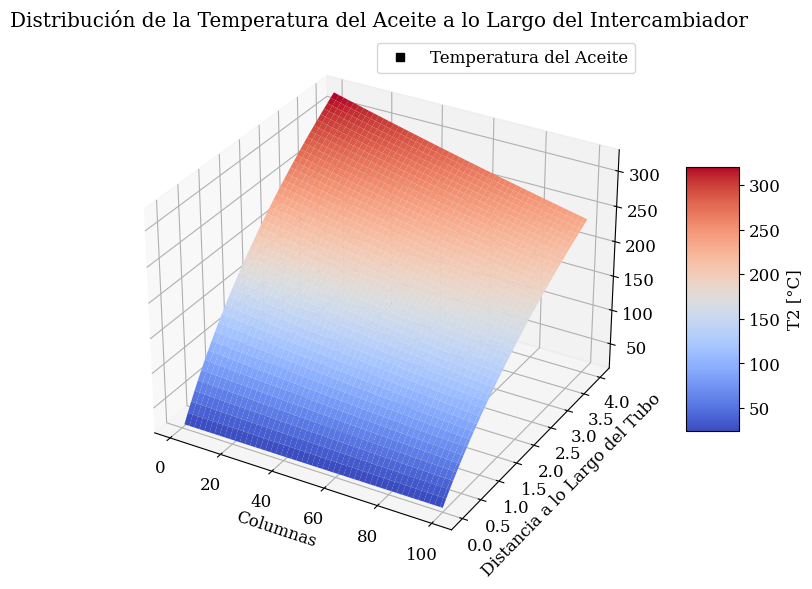

In [54]:
#---------------------------------

T1_i = 800+273.15  # Temperatura inicial del gas
T1_o_exit = T1_i - 150  # Se fija de esta manera la suposicion a la salida
T1_m = (T1_i + T1_o_exit)/2

T2_i = 20+273.15  # Temperatura incial del aceite

#---------------------------------

Nf,Nc,Ly,Z,Ny,m1,m2,dis = map(float,pedir_parametros())# Se piden los parametros al usuario

Nf,Nc,Ny,dis = int(Nf),int(Nc),int(Ny),int(dis)

kt,do,di,ro,ri = propiedades_tubos()  # Parámetros del tubo

kf,de,t,sigmaf,re,N_aletas = propiedades_aletas() # Parámetros de aletas

dy,dA1,dA2,Rw = calcular_constantes() # Cálculo de constantes

#----------------------------------

 
T1 = np.zeros(Nc+1) # Se inicializa array T1
T1[0] = T1_i
T1[Nc] = T1_o_exit

if dis == 0:
    m2 = np.full(Nc,m2/Nc)
elif dis ==1:
    m2x1 = np.linspace(1,2,Nc//2)
    m2x2 = np.linspace(2,1,Nc//2)
    if Nc%2 != 0:
        m2x = np.concatenate((m2x1,np.array([2+2/Nc]),m2x2))
    else: 
        m2x = np.concatenate((m2x1,m2x2))
    m2 = m2x*m2/np.sum(m2x)
elif dis == 2:
    m2x = np.linspace(1,2,Nc)
    m2 = m2x*m2/np.sum(m2x)
elif dis == 3:
    m2x = np.linspace(2,1,Nc)
    m2 = m2x*m2/np.sum(m2x)

#m2 = np.full(Nc,m2/Nc) # Array flujos másicos aceite
T2 = np.zeros((Nc,Ny+1)) # Se inicializa array T2
T2[:,0] = np.full(Nc,T2_i)

#------------------------------------


n = 0
error = 0.01  # Error en T1_o
e = error + 1


while e > error:   # Loop principal
    n += 1  # Número de iteraciones 
    T1_o = T1_o_exit
    T1_m = (T1_i + T1_o)/2
    for i in range(Nc):
        cp1 = cp_gas(T1[i])  # Se calculan las propiedades del gas
        rho1 = densidad_gas(T1_m)
        k1 = conductividad_gas(T1_m)
        miu1 = viscosidad_gas(T1_m)
        Pr1 = Pr_gas(T1_m)
        h1 = calcular_h1()  # Coeficiente de convección
        eta_f = calcular_etaf() # Eficiencia de las aletas
        
        S0 = 0  # Se aprovecha de almacenar una suma aquí para no repetir loop
        for j in range(Ny):
            cp2 = cp_oil(T2[i,j]) # Se calculan propiedades del aceite
            rho2 = densidad_oil(T2[i,j])
            k2 = conductividad_oil(T2[i,j])
            miu2 = viscosidad_oil(T2[i,j])
            h2 = h2_ij(i,j) # Coeficiente de convección
            U_ij = calcular_Uij() # Coeficiente U
            T2[i,j+1] = T2[i,j] + U_ij*dA2/(cp2*m2[i])*(T1[i]-T2[i,j]) # Temperatura en nodo j+1
            if T2[i,j+1] > 340 + 273.15:
                print(f'Se superó la temperatura máxima del aceite, T2={T2[i,j+1]}')
    
            S0 += U_ij*(T1[i]-T2[i,j]) # La suma que se habló (para calcular T1)     
        T1[i+1] = T1[i] - dA2/(cp1*m1)*S0  # Se calcula T1 en la siguiente columna
    T1_o_exit = T1[Nc]
    e = np.abs(T1_o - T1_o_exit) # Se verifica error

T1_o = T1_o_exit

#---------------------------

# Se calcula T2_o
S1 = 0
S2 = 0
for i in range(Nc):
    S1 += m2[i]*cp_oil(T2[i,Ny])*T2[i,Ny]
    S2 += m2[i]*cp_oil(T2[i,Ny])
T2_o = S1/S2
    
#----------------------------

#Se calcula el flujo de calor
Q = 0
for i in range(Nc):
    Q += m1*cp_gas(T1[i])*(np.abs(T1[i+1]-T1[i]))

Q = np.abs(Q)
#----------------------------

T1 -= 273.15
T2 -= 273.15
T1_o -= 273.15
T2_o -= 273.15

print("")
print("----------------------")
print("Tamaño del Intercambiador:")
print(f'Alto: {np.round(Z*Nf, decimals=2)} [m]')
print(f'Ancho: {np.round(Z*Nc, decimals=2)} [m]')
print(f'Largo: {np.round(Ly, decimals=2)} [m]')
print("----------------------")
print("Resultados:")
print(f'Número de iteraciones {n}')
print(f'Temperatura de salida del gas: {np.round(T1_o, decimals=1)} [°C]')
print(f'Temperatura de salida del aceite: {np.round(T2_o, decimals=1)} [°C]')
print(f'Flujo de calor total transferido: {np.round(Q/1000, decimals=1)} [kW]')
    
graficar()  #Se grafican resultados

#save_csv() #Se guardan en archivo csv las temperaturas


In [52]:
T2[0,Ny+1]

IndexError: index 45 is out of bounds for axis 1 with size 45

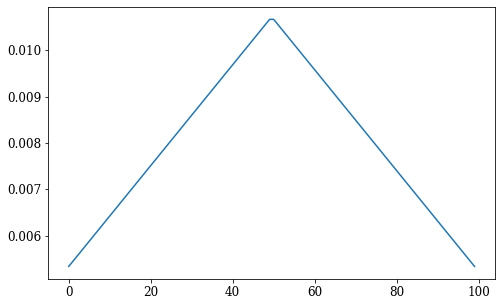

In [49]:
plt.plot(m2)

In [43]:
m2

array([0.04656085, 0.05820106, 0.06984127, 0.08148148, 0.09312169,
       0.1015873 , 0.09312169, 0.08148148, 0.06984127, 0.05820106,
       0.04656085])

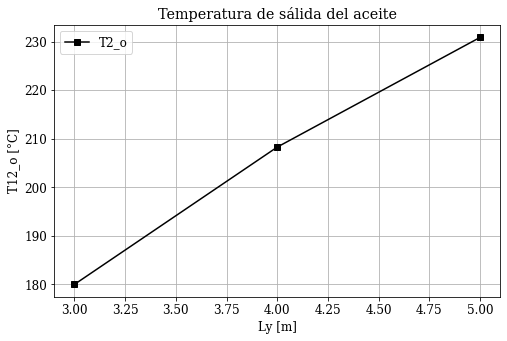

In [63]:
T = [180,208.3,230.9]
L = [3,4,5]
x = np.linspace(1,Nc,Nc)
plt.plot(L,T,c='k', ls='-', marker='s', label="T2_o")
plt.title("Temperatura de sálida del aceite")
plt.ylabel("T12_o [°C]")
plt.xlabel("Ly [m]")
plt.legend(loc="best")
plt.grid()
plt.show()

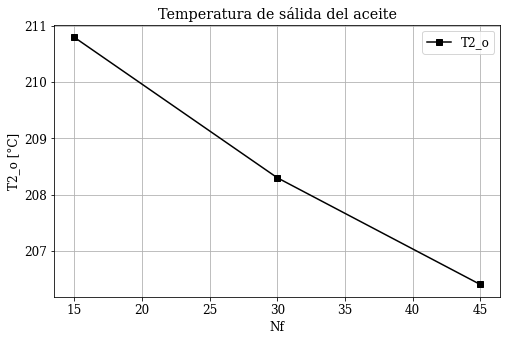

In [80]:
T = [210.8,208.3,206.4]
L = [15,30,45]
x = np.linspace(1,Nc,Nc)
plt.plot(L,T,c='k', ls='-', marker='s', label="T2_o")
plt.title("Temperatura de sálida del aceite")
plt.ylabel("T2_o [°C]")
plt.xlabel("Nf")
plt.legend(loc="best")
plt.grid()
plt.show()

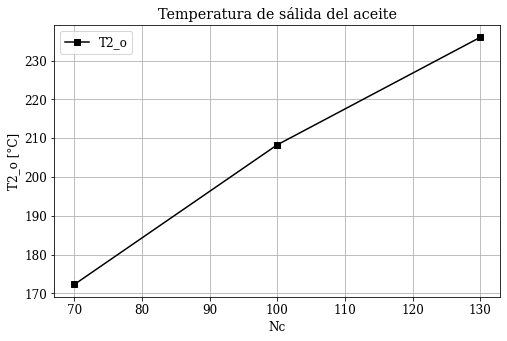

In [79]:
T = [172.3,208.3,236]
L = [70,100,130]
x = np.linspace(1,Nc,Nc)
plt.plot(L,T,c='k', ls='-', marker='s', label="T2_o")
plt.title("Temperatura de sálida del aceite")
plt.ylabel("T2_o [°C]")
plt.xlabel("Nc")
plt.legend(loc="best")
plt.grid()
plt.show()